# Import libraries

In [1]:
from fastbook import *
from fastai.vision.all import *

# From dogs and cats to pet breeds

In [2]:
# Retrieve data from kaggle's pet breed competition
path = untar_data(URLs.PETS)

In [3]:
# Reviewing the data
path.ls()

(#2) [Path('/Users/adgb/.fastai/data/oxford-iiit-pet/images'),Path('/Users/adgb/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
# Update the base path to be the pet competition folder path
Path.BASE_PATH = path

In [5]:
# Review data
path.ls()

(#2) [Path('images'),Path('annotations')]

The annotations folder include information on where the images were taken. This will be ignored as we will be working with a classification problem.

In [6]:
# Exploring images folder
(path/'images').ls()

(#7393) [Path('images/Egyptian_Mau_167.jpg'),Path('images/pug_52.jpg'),Path('images/basset_hound_112.jpg'),Path('images/Siamese_193.jpg'),Path('images/shiba_inu_122.jpg'),Path('images/Siamese_53.jpg'),Path('images/Birman_167.jpg'),Path('images/leonberger_6.jpg'),Path('images/Siamese_47.jpg'),Path('images/shiba_inu_136.jpg')...]

In [7]:
# Extracting the category from the image name using regex
fname = (path/'images').ls()[0]
re.findall(r'(.+)_\d+.jpg$',fname.name)

['Egyptian_Mau']

The regex expression looks for strings that:
- `(.+)` include a group of one or more alphanumeric characters
- `_\d+.jpg$` followed by an underscore (`_`), one or more digits (`\d+`), a full stop and the string 'jpg' (`.jgp`), and the end of the string (`$`).

We will label the dataset using a `DataBlock` object. The `DataBlock` object needs:
- The types of data we are working with
- How to get the list of items
- How to label the items
- How to create a validation set

In [8]:
# Label the dataset using a DataBlock object
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224,min_scale=0.75)
)
dls = pets.dataloaders(path/'images',num_workers=0)

`DataLoader` structure:

- `blocks=(ImageBlock,CategoryBlock)`: types for the independent and dependent variables
- `get_items=get_image_files`: get the list of files based on a path
- `splitter=RandomSplitter(seed=42)`: randomly split tranin and validation sets
- `get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name')`: get labels applying regex on the name attribute
- `item_tfms=Resize(460)`: resize each image to 460 pixels. This operation performed in the CPU. On the training set, the crop area is chosen randomly while on the validation set the crop area is centered.
- `batch_tfms=aug_transforms(size=224,min_scale=0.75)`: apply transformations to all images in batch with the GPU. This will apply all transformation in testing sets but only resizing in validation sets. When using the `min_scale` parameter of `aug_transforms`, `RandomResizedCrop` is automatically applied.

## Presizing

In [9]:
# Presizing example

# Create a data block
dblock1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_y=parent_label,
                    item_tfms=Resize(460))

In [10]:
# Create a data loader
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100,bs=80)
dls1.train.get_idxs = lambda: Inf.ones

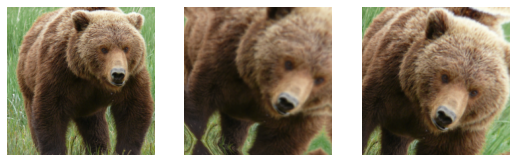

In [11]:
# Extract one batch from data loader
x,y = dls1.valid.one_batch()

# Create canvas for plots
_,axs = subplots(1, 3)

# Create an image with traditional augmentations
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Create a FastAI transforms pipeline
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., 
                                                            size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])

# Apply the FastAI transforms pipeline
x2 = TensorImage(x.clone())
x2 = Pipeline(tfms)(x)

# Show images in plot canvas
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1])
TensorImage(x2[0]).show(ctx=axs[2]);

## Checking and debugging a DataBlock

The `show_batch` method allows us to review the batch images and the classes

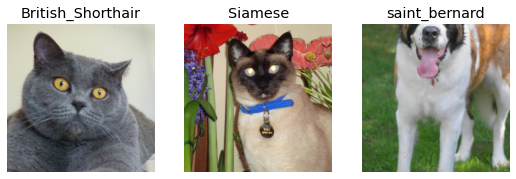

In [12]:
dls.show_batch(nrows=1, ncols=3)

The `summary` method allows us to debug the `DataBlock`. The code below fails because there is no resizing of the images so they cannot be added into a tensor.

In [13]:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'))
pets1.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/adgb/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/adgb/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 375])
	Item at index 1 has shape: torch.Size([3, 333, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

Once the `DataBlock` is ready. It is recommendable to create a simple model and test the results.

In [14]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.512735,0.318540,0.103518,20:14


epoch,train_loss,valid_loss,error_rate,time
0,0.538160,0.308338,0.091340,27:01
1,0.333680,0.225439,0.069689,26:36


# Cross-Entropy Loss

Cross-Entropy loss is a loss function used for categorical data. To understand how it works, we will dive into the activations and data that the function sees

## Viewing Activations and Labels

In [15]:
# Extract one batch 
x, y = dls.one_batch()

In [18]:
# Dependent variable
y.shape, y

(torch.Size([64]),
 TensorCategory([ 7, 19,  8,  2, 13, 16, 35, 22, 14, 29, 31, 24, 14,  5,  0, 30, 28, 34, 31, 18, 13, 20, 29, 26, 15, 30, 11, 12, 23, 18,  8, 34, 23, 26,  5, 10, 25, 25,  5,  3, 29, 18,  2, 32, 24, 27, 11, 19,
          7, 31,  8, 22,  7, 36,  0,  4, 27,  4, 25, 24, 15, 28, 36, 36]))

In [19]:
# Get predictions
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([7.4347e-09, 1.0580e-07, 1.9557e-07, 4.1087e-08, 1.2932e-05, 2.8784e-08, 2.4918e-04, 9.9971e-01, 6.5910e-06, 2.3790e-09, 2.3494e-09, 4.7193e-07, 1.4232e-07, 9.5900e-09, 1.5619e-07, 5.0845e-09,
        1.7540e-07, 1.4790e-07, 5.2967e-08, 7.3099e-09, 4.6957e-10, 1.7399e-07, 2.7618e-06, 3.6372e-06, 8.1244e-07, 2.9918e-07, 1.2492e-08, 8.2620e-08, 1.4160e-05, 6.3238e-07, 7.5301e-08, 1.2192e-06,
        1.6443e-08, 3.8937e-08, 6.2175e-08, 2.4979e-08, 2.5136e-07])

In [21]:
preds.shape, preds[0].sum()

(torch.Size([64, 37]), TensorBase(1.0000))

The `get_preds` function allows us to see the predictions based on a dataset index (0 for train and 1 for valid) or an iterator of batches.

This returns 64 lines of 37 predictions. Each corresponding to a dog breed and adding up to 1.

## Softmax

Classifications are passed through a _softmax_ activation function to make sure they range from 0 to 1. It is similar to a _simoid_ function.

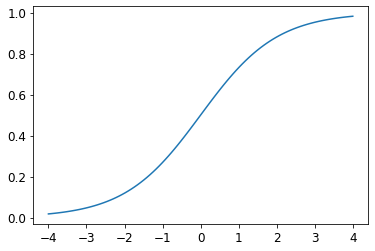

In [23]:
plot_function(torch.sigmoid, min=-4,max=4)

We need to pass our activations for each category through the softmax function to ensure they add up to 1

In [24]:
# Activations example
# Create a random tensor with two categories
acts = torch.randn((6,2))*2
acts

tensor([[-0.4670,  3.8039],
        [-1.3030, -0.7319],
        [ 5.1407, -0.3714],
        [-0.9141, -0.8695],
        [-0.7250,  1.4694],
        [ 0.8748,  1.3960]])

If we take the sigmoid directly, the probabilities of the two categories for each predictino will not add up to 1.

In [32]:
acts.sigmoid(), acts.sigmoid().sum(dim=0),acts.sigmoid().sum(dim=1),acts.sigmoid().sum()

(tensor([[0.3853, 0.9782],
         [0.2137, 0.3248],
         [0.9942, 0.4082],
         [0.2862, 0.2953],
         [0.3263, 0.8130],
         [0.7057, 0.8015]]),
 tensor([2.9114, 3.6210]),
 tensor([1.3635, 0.5384, 1.4024, 0.5815, 1.1393, 1.5073]),
 tensor(6.5324))

In [34]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.0138, 0.3610, 0.9960, 0.4889, 0.1003, 0.3726])